In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import scipy.io
import PIL

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
home_path = "/content/drive/Shareddrives/Data2040FinalProj/data/IIIT5K/"
train_label_path = home_path + "traindata.mat"
test_label_path = home_path + "testdata.mat"
train_image_path = home_path + "train/"
test_image_path = home_path + "test/"

In [ ]:
train_label = scipy.io.loadmat(train_label_path)

In [ ]:
image_1998 =  PIL.Image.open(home_path + train_label['traindata'][0][144][0][0])
image_1998

In [ ]:
train_label['traindata'][0][1998][2]

array([[array(['GREAT'], dtype='<U5'), array(['019901'], dtype='<U6'),
        array(['112009'], dtype='<U6'), array(['1472'], dtype='<U4'),
        array(['16'], dtype='<U2'), array(['226'], dtype='<U3'),
        array(['25'], dtype='<U2'), array(['3061'], dtype='<U4'),
        array(['360'], dtype='<U3'), array(['372SIGN'], dtype='<U7'),
        array(['3A'], dtype='<U2'), array(['53'], dtype='<U2'),
        array(['ALL'], dtype='<U3'), array(['ASHLEY'], dtype='<U6'),
        array(['BERGMAN'], dtype='<U7'),
        array(['BILLBOARDS'], dtype='<U10'),
        array(['BUDDY'], dtype='<U5'), array(['CAN'], dtype='<U3'),
        array(['CERTAINTY'], dtype='<U9'), array(['CITY'], dtype='<U4'),
        array(['CLOSE'], dtype='<U5'), array(['COP'], dtype='<U3'),
        array(['COPS'], dtype='<U4'), array(['COURT'], dtype='<U5'),
        array(['CRAWLING'], dtype='<U8'), array(['DANGER'], dtype='<U6'),
        array(['DECEMBER'], dtype='<U8'),
        array(['DEPOSIT'], dtype='<U7'), arra

In [ ]:
char_label = scipy.io.loadmat(home_path + '/trainCharBound.mat')

In [ ]:
 char_label['trainCharBound'][0][1998]

(array(['train/999_4.png'], dtype='<U15'), array(['Great'], dtype='<U5'), array([[ 6.,  3., 28., 34.],
       [34.,  8., 14., 29.],
       [50., 10., 22., 27.],
       [74., 10., 22., 27.],
       [97.,  5., 15., 32.]], dtype=float32))

## EAST Model Implememtation:

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract

Reading package lists... Done
Building dependency tree       
Reading state information... Done
tesseract-ocr is already the newest version (4.00~git2288-10f4998a-2).
0 upgraded, 0 newly installed, 0 to remove and 30 not upgraded.


In [ ]:
##Loading the necessary packages 
import numpy as np
import cv2
from imutils.object_detection import non_max_suppression
import pytesseract
from matplotlib import pyplot as plt
import os

/content/drive/Shareddrives/Data2040FinalProj/data/IIIT5K/train/


In [ ]:
from imutils import paths

data = []

#TODO: Grab list of image paths using paths.list_images
imagePaths = paths.list_images(train_image_path[:100])

for imagePath in imagePaths:
  image = cv2.imread(imagePath)
  #Saving a original image and shape
  orig = image.copy()
  (origH, origW) = image.shape[:2]

  # set the new height and width to default 320 by using args #dictionary.  
  (newW, newH) = (32, 32 )

  #Calculate the ratio between original and new image for both height and weight. 
  #This ratio will be used to translate bounding box location on the original image. 
  rW = origW / float(newW)
  rH = origH / float(newH)

  # resize the original image to new dimensions
  image = cv2.resize(image, (newW, newH))
  image = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
  (H, W) = image.shape[:2]

  # construct a blob from the image to forward pass it to EAST model
  blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
    (123.68, 116.78, 103.94), swapRB=True, crop=False)

  data.append(blob)

## EAST Model

In [ ]:
# load the pre-trained EAST model for text detection 
east_path = "/content/drive/Shareddrives/Data2040FinalProj/EAST_model/frozen_east_text_detection.pb"
net = cv2.dnn.readNet(east_path)
# We would like to get two outputs from the EAST model. 
#1. Probabilty scores for the region whether that contains text or not. 
#2. Geometry of the text -- Coordinates of the bounding box detecting a text
# The following two layer need to pulled from EAST model for achieving this. 
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

## Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < 0.5:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and associated confidence_val
	return (boxes, confidence_val)

In [ ]:
# Find predictions and  apply non-maxima suppression
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

In [ ]:
##Text Detection and Recognition 

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	#extract the region of interest
	r = orig[startY:endY, startX:endX]

	#configuration setting to convert image to string.  
	configuration = ("-l eng --oem 1 --psm 8")
    ##This will recognize the text from the image of bounding box
	text = pytesseract.image_to_string(r, config=configuration)

	# append bbox coordinate and associated text to the list of results 
	results.append(((startX, startY, endX, endY), text))

In [ ]:
print(results)

[]


 TANGE!




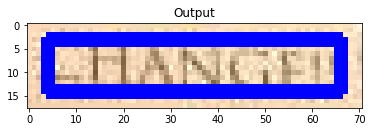

In [ ]:
#Display the image with bounding box and recognized text
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 224 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(orig_image)
plt.title('Output')
plt.show()

## Noise reduction:

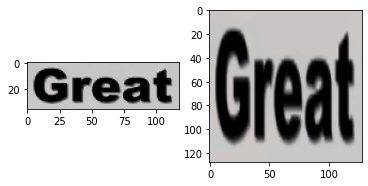

In [ ]:


import numpy as np
import cv2
from matplotlib import pyplot as plt


image = cv2.imread(home_path + train_label['traindata'][0][1998][0][0])
# orig = image.copy()
# (origH, origW) = image.shape[:2]

# # # set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (128, 128 )

# # #Calculate the ratio between original and new image for both height and weight. 
# # #This ratio will be used to translate bounding box location on the original image. 
# rW = origW / float(newW)
# rH = origH / float(newH)

# resize the original image to new dimensions
newimage = cv2.resize(image, (newW, newH))
newimage = cv2.fastNlMeansDenoisingColored(newimage,None,10,10,7,21)
# (H, W) = image.shape[:2]

# # # construct a blob from the image to forward pass it to EAST model
# blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
#    (123.68, 116.78, 103.94), swapRB=True, crop=False)



dst = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
plt.subplot(121),plt.imshow(image)
plt.subplot(122),plt.imshow(newimage)
#plt.subplot(122),plt.imshow(blob[0].transpose())
plt.show()



## Baseline Prediction EAST:

In [ ]:
imagePath =(home_path + train_label['traindata'][0][77][0][0])

image = cv2.imread(imagePath)
#Saving a original image and shape
orig = image.copy()
(origH, origW) = image.shape[:2]

# set the new height and width to default 320 by using args #dictionary.  
(newW, newH) = (64, 64 )

#Calculate the ratio between original and new image for both height and weight. 
#This ratio will be used to translate bounding box location on the original image. 
rW = origW / float(newW)
rH = origH / float(newH)

# resize the original image to new dimensions
image = cv2.resize(image, (newW, newH))
image = cv2.fastNlMeansDenoisingColored(image,None,10,10,7,21)
(H, W) = image.shape[:2]

# construct a blob from the image to forward pass it to EAST model
blob = cv2.dnn.blobFromImage(image, 1.0, (W, H),
(123.68, 116.78, 103.94), swapRB=True, crop=False)


In [ ]:
# load the pre-trained EAST model for text detection 
east_path = "/content/drive/Shareddrives/Data2040FinalProj/EAST_model/frozen_east_text_detection.pb"
net = cv2.dnn.readNet(east_path)
# We would like to get two outputs from the EAST model. 
#1. Probabilty scores for the region whether that contains text or not. 
#2. Geometry of the text -- Coordinates of the bounding box detecting a text
# The following two layer need to pulled from EAST model for achieving this. 
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]

net.setInput(blob)
(scores, geometry) = net.forward(layerNames)

## Returns a bounding box and probability score if it is more than minimum confidence
def predictions(prob_score, geo):
	(numR, numC) = prob_score.shape[2:4]
	boxes = []
	confidence_val = []

	# loop over rows
	for y in range(0, numR):
		scoresData = prob_score[0, 0, y]
		x0 = geo[0, 0, y]
		x1 = geo[0, 1, y]
		x2 = geo[0, 2, y]
		x3 = geo[0, 3, y]
		anglesData = geo[0, 4, y]

		# loop over the number of columns
		for i in range(0, numC):
			if scoresData[i] < 0.5:
				continue

			(offX, offY) = (i * 4.0, y * 4.0)

			# extracting the rotation angle for the prediction and computing the sine and cosine
			angle = anglesData[i]
			cos = np.cos(angle)
			sin = np.sin(angle)

			# using the geo volume to get the dimensions of the bounding box
			h = x0[i] + x2[i]
			w = x1[i] + x3[i]

			# compute start and end for the text pred bbox
			endX = int(offX + (cos * x1[i]) + (sin * x2[i]))
			endY = int(offY - (sin * x1[i]) + (cos * x2[i]))
			startX = int(endX - w)
			startY = int(endY - h)

			boxes.append((startX, startY, endX, endY))
			confidence_val.append(scoresData[i])

	# return bounding boxes and associated confidence_val
	return (boxes, confidence_val)


In [ ]:
# Find predictions and  apply non-maxima suppression
(boxes, confidence_val) = predictions(scores, geometry)
boxes = non_max_suppression(np.array(boxes), probs=confidence_val)

##Text Detection and Recognition 

# initialize the list of results
results = []

# loop over the bounding boxes to find the coordinate of bounding boxes
for (startX, startY, endX, endY) in boxes:
	# scale the coordinates based on the respective ratios in order to reflect bounding box on the original image
	startX = int(startX * rW)
	startY = int(startY * rH)
	endX = int(endX * rW)
	endY = int(endY * rH)

	#extract the region of interest
	r = orig[startY:endY, startX:endX]

	#configuration setting to convert image to string.  
	configuration = ("-l eng --oem 1 --psm 8")
    ##This will recognize the text from the image of bounding box
	text = pytesseract.image_to_string(r, config=configuration)

	# append bbox coordinate and associated text to the list of results 
	results.append(((startX, startY, endX, endY), text))

Smile_




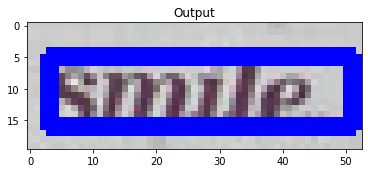

In [ ]:
#Display the image with bounding box and recognized text
orig_image = orig.copy()

# Moving over the results and display on the image
for ((start_X, start_Y, end_X, end_Y), text) in results:
	# display the text detected by Tesseract
	print("{}\n".format(text))

	# Displaying text
	text = "".join([x if ord(x) < 224 else "" for x in text]).strip()
	cv2.rectangle(orig_image, (start_X, start_Y), (end_X, end_Y),
		(0, 0, 255), 2)
	cv2.putText(orig_image, text, (start_X, start_Y - 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.7,(0,0, 255), 2)

plt.imshow(orig_image)
plt.title('Output')
plt.show()